<a href="https://colab.research.google.com/github/adrienGuillotS/Mecagent/blob/main/mecagent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ENV SETUP

1. Install uv (or do it you're own way)
2. Run `uv sync`
3. Run `source .venv/bin/activate`

You're good to go.

In [ ]:
!pip install uv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 74.3 MB/s eta 0:00:00


In [ ]:
!uv sync

Using CPython 3.11.13 interpreter at: /usr/bin/python3
Creating virtual environment at: .venv
Resolved 76 packages in 1ms
⠙ Preparing packages... (0/70)
⠙ Preparing packages... (0/70)
⠙ Preparing packages... (0/70)
tzdata               ------------------------------     0 B/339.69 KiB
⠙ Preparing packages... (0/70)
tzdata               ------------------------------     0 B/339.69 KiB
⠙ Preparing packages... (0/70)
tzdata               ------------------------------     0 B/339.69 KiB
⠙ Preparing packages... (0/70)
python-dateutil      ------------------------------     0 B/224.50 KiB
tzdata               ------------------------------     0 B/339.69 KiB
⠙ Preparing packages... (0/70)
python-dateutil      ------------------------------     0 B/224.50 KiB
tzdata               ------------------------------     0 B/339.69 KiB
⠙ Preparing packages... (0/70)
python-dateutil      ------------------------------     0 B/224.50 KiB
tzdata               ------------------------------     0 B/33

In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

# Instructions

The Task : Create the best CadQuery code generator model.

1. Load the dataset (147K pairs of Images/CadQuery code).
2. Create a baseline model and evaluate it with the given metrics.
3. Enhance by any manner the baseline model and evaluate it again.
4. Explain you choices and possible bottlenecks.
5. Show what enhancements you would have done if you had more time.

You can do *WHATEVER* you want, be creative, result is not what matters the most.
Creating new model architectures, reusing ones you used in the past, fine-tuning, etc...

If you are GPU poor, there are solutions. Absolute value is not what matters, relative value between baseline and enhanced model is what matters.

In [2]:
!pip install transformers datasets torchvision tqdm

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

**Import**

In [1]:
import torch
import torch.nn as nn
from transformers import ViTModel, AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm

Dataset

In [6]:
ds = load_dataset("CADCODER/GenCAD-Code", split="train")

**inside the dataset**

In [ ]:
ds[3]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=448x448>,
 'deepcad_id': '0000/00000927',
 'cadquery': 'import cadquery as cq\n# Generating a workplane for sketch 0\nwp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(0.0, 0.0, 0.0), cq.Vector(1.0, 6.123233995736766e-17, -6.123233995736766e-17), cq.Vector(6.123233995736766e-17, -1.0, 6.123233995736766e-17)))\nloop0=wp_sketch0.moveTo(0.296875, 0.0).lineTo(0.296875, 0.296875).lineTo(0.0, 0.296875).lineTo(0.0, 0.0).close()\nsolid0=wp_sketch0.add(loop0).extrude(0.75)\nsolid=solid0\n',
 'token_count': 925,
 'prompt': 'Generate the CADQuery code needed to create the CAD for the provided image. Just the code, no other words.',
 'hundred_subset': False}

cadquery :  import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.015625, -0.0078125, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop0=wp_sketch0.moveTo(0.0, 0.0).threePointArc((0.0007948582418457166, -0.0019189575476279677), (0.0027138157894736844, -0.0027138157894736844)).lineTo(0.021217105263157895, -0.0027138157894736844).threePointArc((0.022787161438489866, -0.00206347722796355), (0.0234375, -0.000493421052631579)).lineTo(0.0234375, 0.018256578947368422).threePointArc((0.02283825686147997, 0.019949990385858287), (0.021217105263157895, 0.020723684210526318)).lineTo(0.0022203947368421052, 0.020723684210526318).threePointArc((0.0005992431385200307, 0.019949990385858287), (0.0, 0.018256578947368422)).lineTo(0.0, 0.0).close()
solid0=wp_sketch0.add(loop0).extrude(0.75)
solid=solid0

prompt :  Generate the CADQuery code needed to create the CAD for the provided image. Just the code, no other words.


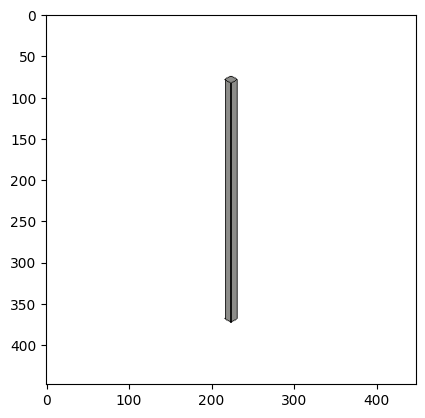

cadquery :  import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(0.0, -0.1953125, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop0=wp_sketch0.moveTo(0.17730263157894738, 0.0).lineTo(0.17730263157894738, 0.38281250000000006).lineTo(0.0, 0.38281250000000006).lineTo(0.0, 0.0).close()
solid0=wp_sketch0.add(loop0).extrude(0.3046875)
solid=solid0
# Generating a workplane for sketch 1
wp_sketch1 = cq.Workplane(cq.Plane(cq.Vector(0.1796875, -0.109375, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))
loop1=wp_sketch1.moveTo(0.3782072368421052, 0.0).lineTo(0.5703125, 0.1140625).lineTo(0.3782072368421052, 0.22212171052631577).lineTo(0.0, 0.22212171052631577).lineTo(0.0, 0.0).close()
solid1=wp_sketch1.add(loop1).extrude(0.1796875)
solid=solid.union(solid1)

prompt :  Generate the CADQuery code needed to create the CAD for the provided image. Just the code, no other words.


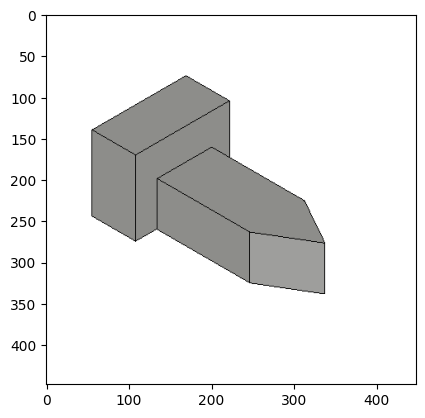

cadquery :  import cadquery as cq
# Generating a workplane for sketch 0
wp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.1015625, 0.0, -0.046875), cq.Vector(1.0, 6.123233995736766e-17, -6.123233995736766e-17), cq.Vector(6.123233995736766e-17, -1.0, 6.123233995736766e-17)))
loop0=wp_sketch0.moveTo(0.0, 0.0).threePointArc((0.0019490941863378162, -0.04433658679437616), (0.03355263157894737, -0.07549342105263158)).threePointArc((0.09646381578947369, -0.08720656501962193), (0.159375, -0.07549342105263158)).threePointArc((0.19097853739260956, -0.044336586794376284), (0.19292763157894738, 0.0)).lineTo(0.14259868421052632, 0.18453947368421053).lineTo(0.14259868421052632, 0.796875).lineTo(0.10904605263157895, 0.796875).lineTo(0.10904605263157895, 0.7381578947368421).lineTo(0.08388157894736842, 0.7381578947368421).lineTo(0.08388157894736842, 0.796875).lineTo(0.0587171052631579, 0.796875).lineTo(0.0587171052631579, 0.18453947368421053).lineTo(0.0, 0.0).close()
loop1=wp_sketch0.moveTo(0.0, 0.0).thr

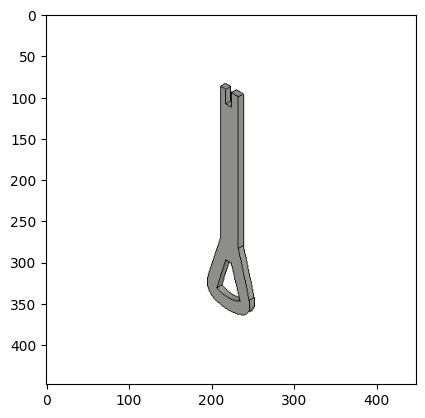

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt

# Charger les 3 premiers exemples
ds = load_dataset("CADCODER/GenCAD-Code", split="train").select(range(3))

# Afficher les images + code CadQuery
for example in (ds):
    print("cadquery : ",example["cadquery"])
    print("prompt : ",example["prompt"])
    plt.imshow(example["image"])
    plt.show()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

architecture

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# encodeur image ViT
vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
vit.eval()
for param in vit.parameters():
    param.requires_grad = False

# proj ViT vers embedding texte (768 -> 512)
class ImageToTextEmbed(nn.Module):
    def __init__(self, vit_dim=768, text_emb_dim=512):
        super().__init__()
        self.proj = nn.Linear(vit_dim, text_emb_dim)
    def forward(self, x):
        return self.proj(x)

image_to_text = ImageToTextEmbed().to(device)

tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("Salesforce/codet5-small").to(device)

# viT + projection + CodeT5 décodeur
class ImageToCodeT5(nn.Module):
    def __init__(self, vit, projection, decoder):
        super().__init__()
        self.vit = vit
        self.projection = projection  # Linear(768 -> 512)
        self.decoder = decoder

    def forward(self, pixel_values, decoder_input_ids, attention_mask=None, labels=None):
        with torch.no_grad():
            vit_outputs = self.vit(pixel_values)
            cls_embeddings = vit_outputs.last_hidden_state[:, 0]

        # proj 768->512
        img_embeds = self.projection(cls_embeddings)

        # (batch, seq_len, 512)
        inputs_embeds = self.decoder.get_input_embeddings()(decoder_input_ids)

        inputs_embeds[:, 0, :] = img_embeds

        # decodeur
        outputs = self.decoder(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels
        )
        return outputs

model_custom = ImageToCodeT5(vit=vit, projection=image_to_text.proj, decoder=model).to(device)

preprocessing and Dataloader

In [11]:
# preprocessing images
def preprocess(examples):
    from torchvision import transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    images = [transform(img) for img in examples['image']]
    examples['pixel_values'] = torch.stack(images)

    tokenized = tokenizer(examples['cadquery'], padding='max_length', truncation=True, max_length=128)
    examples['input_ids'] = tokenized.input_ids
    examples['attention_mask'] = tokenized.attention_mask
    return examples

ds.set_transform(preprocess)

# dataLoader avec collate_fn
def collate_fn(batch):
    pixel_values = torch.stack([x['pixel_values'] for x in batch]).to(device)
    input_ids = torch.tensor([x['input_ids'] for x in batch]).to(device)
    attention_mask = torch.tensor([x['attention_mask'] for x in batch]).to(device)
    return pixel_values, input_ids, attention_mask

loader = DataLoader(ds, batch_size=16, shuffle=True, collate_fn=collate_fn)

optimizer = AdamW(list(model_custom.projection.parameters()) + list(model_custom.decoder.parameters()), lr=5e-5)

training

In [12]:
# 8 epoch
model_custom.train()
for epoch in range(8):
    loop = tqdm(loader)
    for pixel_values, input_ids, attention_mask in loop:
        optimizer.zero_grad()
        outputs = model_custom(
            pixel_values=pixel_values,
            decoder_input_ids=input_ids,
            attention_mask=attention_mask,
            labels=input_ids
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

print("Entraînement terminé")
torch.save(image_to_text.state_dict(), "mon_modele_codet5/projection.pth")


model.save_pretrained("mon_modele_codet5")
tokenizer.save_pretrained("mon_modele_codet5")

Epoch 0:   1%|          | 70/9206 [00:43<1:33:49,  1.62it/s, loss=0.00296]


KeyboardInterrupt: 

BEAUCOUP TROP LONG !

Inference

In [14]:
def generate_from_image(model_custom, pixel_values, tokenizer, max_length=128):
    model_custom.eval()

        vit_outputs = model_custom.vit(pixel_values)
        cls_embeddings = vit_outputs.last_hidden_state[:, 0]
        img_embeds = model_custom.projection(cls_embeddings)
        generated = torch.full((pixel_values.size(0), 1), tokenizer.pad_token_id, dtype=torch.long).to(device)

        for _ in range(max_length):

            inputs_embeds = model_custom.decoder.get_input_embeddings()(generated)
            inputs_embeds[:, 0, :] = img_embeds

            decoder_outputs = model_custom.decoder.decoder(
                inputs_embeds=inputs_embeds,
                attention_mask=torch.ones_like(generated),
                encoder_hidden_states=None,
                encoder_attention_mask=None,
                return_dict=True
            )

            sequence_output = decoder_outputs.last_hidden_state
            logits = model_custom.decoder.lm_head(sequence_output)

            next_token_logits = logits[:, -1, :]
            next_token_id = next_token_logits.argmax(dim=-1, keepdim=True)

            generated = torch.cat([generated, next_token_id], dim=1)

            if (next_token_id == tokenizer.eos_token_id).all():
                break

    return tokenizer.batch_decode(generated[:, 1:], skip_special_tokens=True)[0]

img = Image.open("image.jpg").convert("RGB")
pixel_values = transform(img).unsqueeze(0).to(device)

text = generate_from_image(model_custom, pixel_values, tokenizer)
print("Résultat :", text)


IndentationError: unexpected indent (ipython-input-14-1035609580.py, line 4)